## Getting the notebook into this state

I've experimented with the true value of the parameter quite a bit in previous runs. The parameter corresponds to the frequency of the oscillation. Since the solution is sample at a finite (and low) number of points in time, we need the parameter to be of a certain magnitude in order to recover it well.

The other thing is that the regularisation parameter (p) needs to be tuned so taht it does not dominate the objective (data fit and model fit), especially when comparing to the size of p (model fit regulariastion). We experiment in another notebook with doing this dynamically.

Also the method only works well when the obsevrational error is small in magnitude compared to the actual data.

In [1]:
import modeller
import fitter

import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [13, 8]

In [3]:
p_true = [0.75]
tspan = [0, 20]
def system(t, y, p):
    return [
        p[0]*y[1]*(p[0]-y[0]),
        -p[0]*y[0]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [0.5, 0.5], dense_output=True)

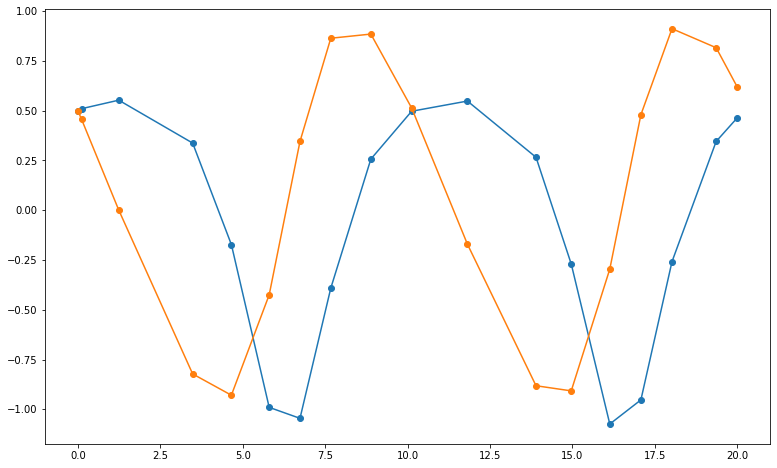

In [4]:
plt.plot(sol.t, sol.y.T, 'o-')

In [5]:
neat_ts = np.linspace(*tspan, 12)
raw_data = sol.sol(neat_ts)[0]
# data = raw_data + np.random.randn(10)*0.5
data = np.random.multivariate_normal(raw_data, 0.2*np.exp(-1/(2*0.04**2)*np.abs(raw_data.reshape(1,-1)-raw_data.reshape(-1,1))**2)).reshape(1,-1)

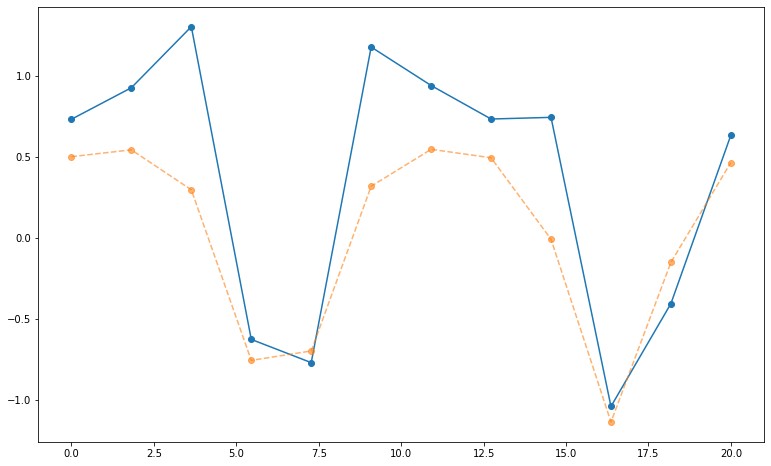

In [6]:
plt.plot(neat_ts, data.T, 'o-')
plt.plot(neat_ts, raw_data.T, 'o--', alpha=0.6)

In [7]:
data_pd = np.array([[i] for i in list(data.flatten())])
# data_pd = np.array([list(i) for i in data.T])
config = {
    "grid_size": 100,
    "basis_number": 20,
    "model_form": {
        "state": 2,
        "parameters": 1
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": data_pd, "t": neat_ts},
    "observation_vector": [0],
    "weightings":[
        [1]*1,
        [1]*len(neat_ts)
    ],
    "regularisation_value": [0],
}

In [8]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.ps),
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

In [9]:
p0 = 1.5
c0 = np.ones(config['basis_number']*2)
x0 = np.hstack([*c0, p0])
# lbx = [-np.inf]*(config['basis_number']*2) + [0]*len(config['regularisation_value'])

In [10]:
prange = np.logspace(-6, 6, num=200)
solutions = []
xguess = x0
for p in prange:
    solutions.append(solver(x0=xguess, p=[p, 1e-10], lbg=0))
    xguess = np.array(solutions[-1]['x']).flatten()
#     xguess += np.random.randn()*np.mean(xguess)/40


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:      861

Total number of variables............................:       41
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:      861

Total number of variables............................:       41
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.7608980e-07 0.00e+00 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.

                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.0280859e-06 0.00e+00 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  8.0620394e-06 0.00e+00 1.00e-02  -1.7 1.18e-01    -  9.90e-01 1.00e+00f  1
   2  8.1323240e-06 0.00e+00 5.40e-08  -3.8 8.74e-02    -  1.00e+00 1.00e+00f  1
   3  8.0274259e-06 0.00e+00 2.72e-07  -8.6 1.93e-01    -  1.00e+00 1.00e+00f  1
   4  8.0267015e-06 0.00e+00 4.41e-09  -8.6 1.37e-02    -  1.00e+00 1.00e+00f  1



   3  5.3886770e-05 0.00e+00 1.40e-06  -5.7 1.70e-01    -  1.00e+00 1.00e+00f  1
   4  5.3878667e-05 0.00e+00 4.37e-08  -8.6 1.95e-02    -  1.00e+00 1.00e+00f  1
   5  5.3878666e-05 0.00e+00 8.57e-12  -8.6 2.55e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   5.3878665884160150e-05    5.3878665884160150e-05
Dual infeasibility......:   8.5725053039959006e-12    8.5725053039959006e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5063623352079898e-09    2.5063623352079898e-09
Overall NLP error.......:   2.5063623352079898e-09    2.5063623352079898e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian ev

Dual infeasibility......:   8.5517400593988398e-13    8.5517400593988398e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059366289228642e-09    2.5059366289228642e-09
Overall NLP error.......:   2.5059366289228642e-09    2.5059366289228642e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.006

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f     0.000136     0.000138         6
       nlp_g      1.6e-05     

Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 5
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 5
Number of Lagrangian Hessian evaluations             = 4
Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
Total CPU secs in NLP function evaluations           =      0.007

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f     0.000124     0.000125         5
       nlp_g      1.4e-05     1.28e-05         5
    nlp_grad     0.000444     5.53e-05         1
  nlp_grad_f     0.000327     0.000327         6
  nlp_hess_l       0.0062      0.00623         4
   nlp_jac_g      1.2e-05     1.19e-05         6
      solver       0.0118       0.0113         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be mor

   0  2.2463154e-02 0.00e+00 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.2480650e-02 0.00e+00 9.01e-05  -1.7 5.33e-02    -  1.00e+00 1.00e+00f  1
   2  2.2415727e-02 0.00e+00 1.17e-04  -3.8 7.76e-02    -  1.00e+00 1.00e+00f  1
   3  2.2415616e-02 0.00e+00 6.04e-07  -5.7 1.22e-03    -  1.00e+00 1.00e+00f  1
   4  2.2415616e-02 0.00e+00 1.67e-11  -8.6 2.27e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 4

                                   (scaled)                 (unscaled)
Objective...............:   2.2415616040596761e-02    2.2415616040596761e-02
Dual infeasibility......:   1.6657045040731398e-11    1.6657045040731398e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5137733348688354e-09    2.5137733348688354e-09
Overall NLP error.......:   2.5137733348688354e-09    2.5137733348688354e-09


Number of objective function evaluations             = 5
Number of objective gradient evaluations          

  nlp_hess_l      0.00622      0.00651         4
   nlp_jac_g      1.3e-05     1.23e-05         6
      solver        0.014       0.0134         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:      861

Total number of variables............................:       41
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
     

   3  4.2017482e-01 0.00e+00 3.70e-10  -5.7 2.46e-05    -  1.00e+00 1.00e+00f  1
   4  4.2017482e-01 0.00e+00 1.31e-13  -8.6 4.19e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 4

                                   (scaled)                 (unscaled)
Objective...............:   4.2017481840570525e-01    4.2017481840570525e-01
Dual infeasibility......:   1.3060220680399586e-13    1.3060220680399586e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060298980551307e-09    2.5060298980551307e-09
Overall NLP error.......:   2.5060298980551307e-09    2.5060298980551307e-09


Number of objective function evaluations             = 5
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 5
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 5
Number o

   1  8.5721212e-01 0.00e+00 4.22e-03  -1.7 2.76e-02    -  1.00e+00 1.00e+00f  1
   2  8.5720785e-01 0.00e+00 5.49e-05  -3.8 2.47e-03    -  1.00e+00 1.00e+00f  1
   3  8.5720785e-01 0.00e+00 5.66e-09  -5.7 2.21e-05    -  1.00e+00 1.00e+00f  1
   4  8.5720785e-01 0.00e+00 3.76e-13  -8.6 1.86e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 4

                                   (scaled)                 (unscaled)
Objective...............:   8.5720784860596622e-01    8.5720784860596622e-01
Dual infeasibility......:   3.7647662765039058e-13    3.7647662765039058e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059595796559190e-09    2.5059595796559190e-09
Overall NLP error.......:   2.5059595796559190e-09    2.5059595796559190e-09


Number of objective function evaluations             = 5
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 0
Number of inequal

Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
Total CPU secs in NLP function evaluations           =      0.009

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f     0.000154     0.000156         6
       nlp_g      1.6e-05     1.61e-05         6
    nlp_grad      5.8e-05     5.76e-05         1
  nlp_grad_f      0.00042     0.000419         7
  nlp_hess_l      0.00792      0.00794         5
   nlp_jac_g      1.6e-05     1.54e-05         7
      solver       0.0133       0.0133         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Num

Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 6
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
Total CPU secs in NLP function evaluations           =      0.005

EXIT: Optimal Solution Found.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f     0.000141     0.000142         6
       nlp_g      1.7e-05     1.47e-05         6
    nlp_grad     0.000405     5.73e-05         1
  nlp_grad_f     0.000374     0.000374         7
  nlp_hess_l      0.00733      0.00758         5
   nlp_jac_g      1.4e-05     1.33e-05         7
      solver       0.0138       0.0135         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:      861

Total number of variables............................:       41
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.4878560e+00 0.00e+00 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.

In [11]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getc = ca.Function('getc', [solver_setup['x']], model.cs)

f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])

In [12]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutions])

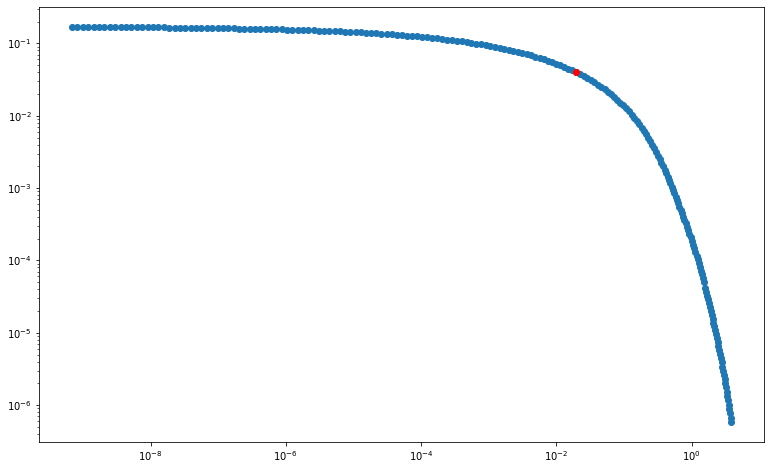

In [13]:
idx = 100
plt.loglog(*fsvals.T, 'o--')
plt.loglog(*fsvals[idx], 'ro')

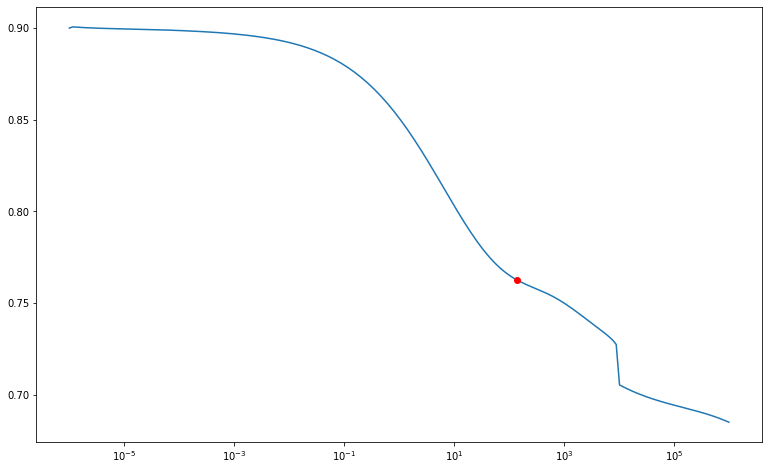

In [14]:
plt.semilogx(prange, [s['x'][-1] for s in solutions])
idx= 135
plt.semilogx(prange[idx], solutions[idx]['x'][-1], 'ro')

0.441877 0.00143756


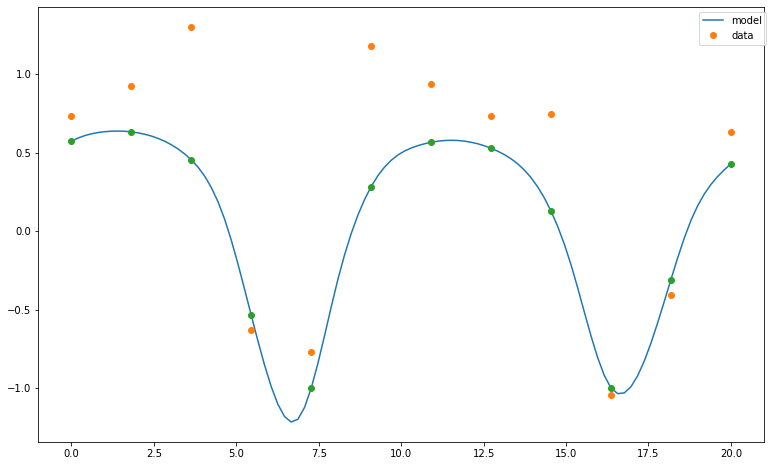

In [15]:
idx = 135
print(f1_ex(solutions[idx]['x']), f2_ex(solutions[idx]['x']))
plt.plot(model.observation_times, getx(solutions[idx]['x'])[0], label='model')
plt.plot(neat_ts, data.T, 'o', label='data')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])[0]).flatten()).T, 'o')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))

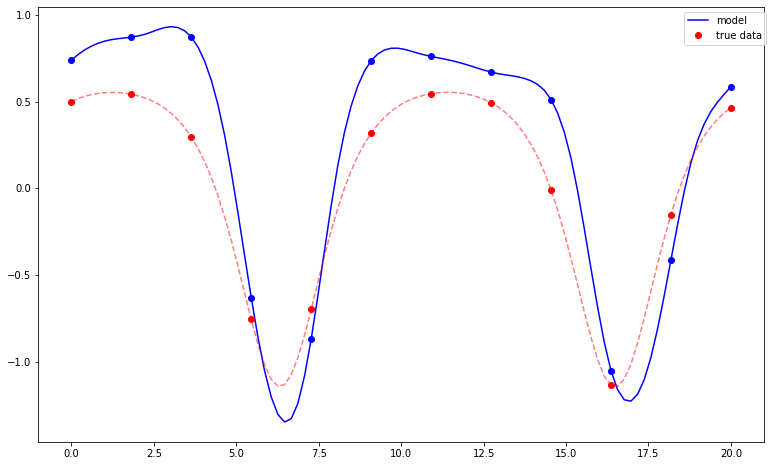

In [16]:
idx = 100
plt.plot(model.observation_times, getx(solutions[idx]['x'])[0], 'b', label='model')
plt.plot(model.observation_times, sol.sol(model.observation_times)[0], 'r--', alpha=0.5)
plt.plot(neat_ts, sol.sol(neat_ts)[0].T, 'ro', label='true data')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])[0]).flatten()).T, 'bo')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))

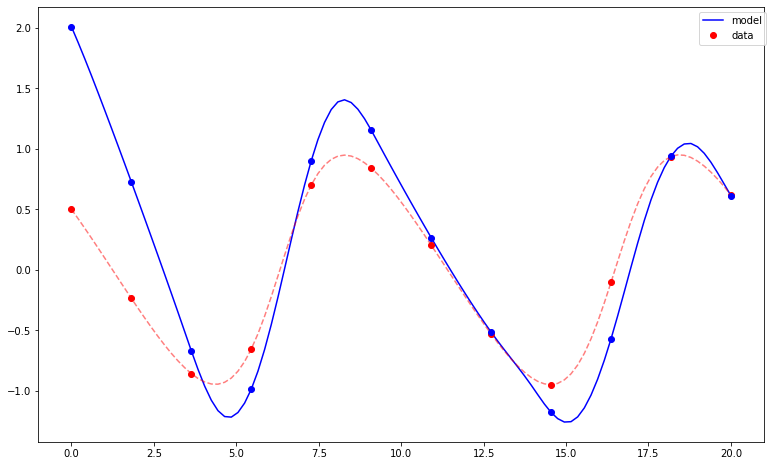

In [17]:
idx = 100
plt.plot(model.observation_times, getx(solutions[idx]['x'])[1], 'b-', label='model')
plt.plot(model.observation_times, sol.sol(model.observation_times)[1], 'r--', alpha=0.5)
plt.plot(neat_ts, sol.sol(neat_ts)[1].T, 'ro', label='data')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])[1]).flatten()).T, 'bo')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))

Text(0, 0.5, '$|| y-c\\Phi ||$')

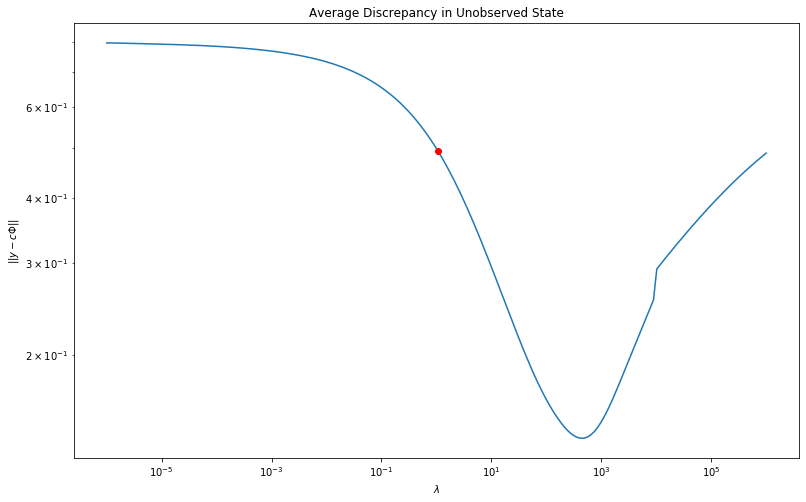

In [18]:
cvfn = lambda idx : np.sqrt(np.sum(((np.array(getx(solutions[idx]['x'])[1]).flatten()) - sol.sol(model.observation_times)[1])**2)/len(model.observation_times))
validation = [cvfn(i) for i in range(200)]
plt.loglog(prange, validation)
idx = 100
plt.loglog(prange[idx], validation[idx], 'ro')
plt.title("Average Discrepancy in Unobserved State")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$|| y-c\Phi ||$")